In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import set_link_color_palette
import matplotlib.colors as mcolors


In [2]:
df = pd.read_parquet("../data/outputs/plots/plot_metrics.parquet")
variant = 'default'
grid_size = 5
grid_agg = 'cv'

default_df = df[(df['variant'] == variant) & (df['grid_size'] == 0)]
default_df = default_df.drop(columns=['min', 'variant', 'grid_size', 'grid_agg', 'site', 'site_type'])

gridded_df = df[(df['variant'] == variant) & (df['grid_size'] == grid_size) & (df['grid_agg'] == grid_agg)]
gridded_df = gridded_df.drop(columns=['min', 'variant', 'grid_size', 'grid_agg', 'site', 'site_type'])
gridded_df = gridded_df.add_prefix(f'xy_{grid_size}m_{grid_agg}|')

# Merge the two dataframes
merged_df = pd.concat([default_df, gridded_df], axis=1)

# merged_df = gridded_df

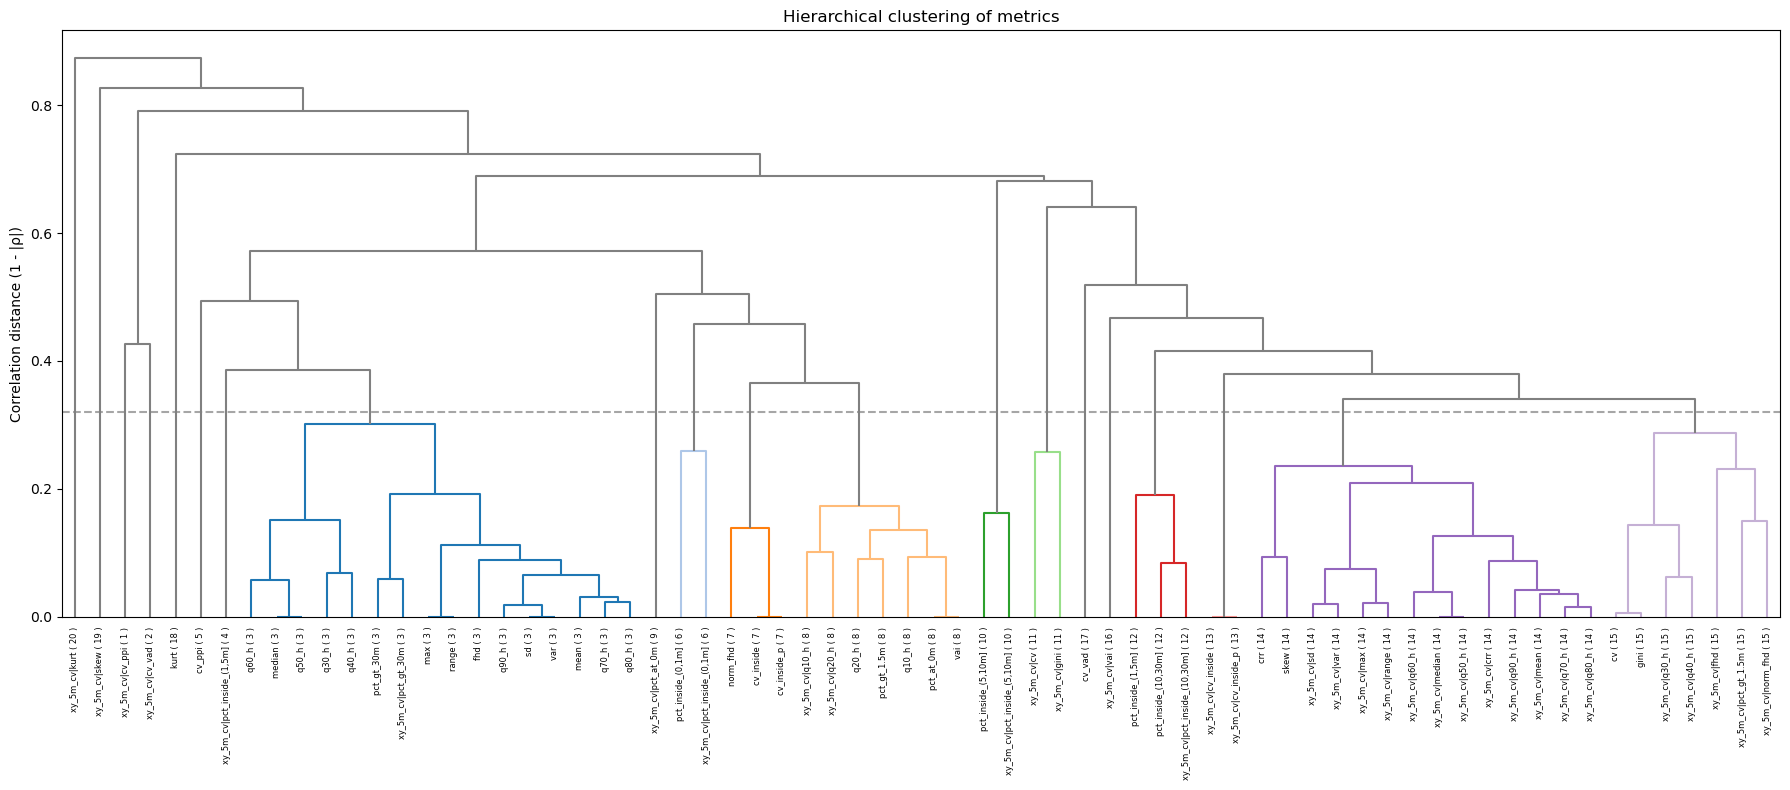

In [5]:
def cluster_metrics_hierarchical(df: pd.DataFrame, method="average", corr_kind="spearman", cut_height=0.3):
    # 1) Correlation between metrics (features)
    corr = df.corr(method=corr_kind)  # (n_metrics x n_metrics)

    # 2) Turn into a distance matrix: 1 - |corr|
    #    Using absolute corr clusters together strongly (±) correlated metrics.
    dist = 1 - corr.abs()

    # 3) Condensed distance vector for scipy
    dist_vec = squareform(dist.values, checks=False)

    # 4) Hierarchical clustering
    Z = linkage(dist_vec, method=method)

    # 5) (Optional) assign cluster labels by cutting the dendrogram at a height
    labels = fcluster(Z, t=cut_height, criterion="distance")  # int labels per metric
    cluster_map = pd.Series(labels, index=corr.index, name="cluster")

    # 6) Quick diagnostics: avg within-cluster |corr|
    diagnostics = []
    for c in np.unique(labels):
        members = cluster_map.index[cluster_map == c]
        sub = corr.loc[members, members].abs()
        # exclude diagonal when computing mean
        mean_offdiag = (sub.where(~np.eye(len(sub), dtype=bool)).stack().mean()
                        if len(sub) > 1 else np.nan)
        diagnostics.append({"cluster": c, "n": len(members), "mean_abs_corr": mean_offdiag})
    diag_df = pd.DataFrame(diagnostics).sort_values("mean_abs_corr", ascending=False)

    return Z, corr, dist, cluster_map, diag_df

cut_off = 0.32
corr_kind = 'spearman'

# --- Example usage ---
# df = ...  # your metrics table (rows = plots, cols = metric names)
Z, corr, dist, cluster_map, diag_df = cluster_metrics_hierarchical(
    merged_df, method="average", corr_kind=corr_kind, cut_height=cut_off
)

# Dendrogram
# Set a color palette for clusters
n_clusters = len(cluster_map.unique())
colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))
set_link_color_palette([mcolors.to_hex(c) for c in colors])

plt.figure(figsize=(18, 8))
cluster_labels = [f"{metric} ( {cluster_map[metric]} )" for metric in corr.index]
dend = dendrogram(Z, labels=cluster_labels, leaf_rotation=90, color_threshold=cut_off, above_threshold_color='gray',)
plt.title("Hierarchical clustering of metrics")
plt.ylabel("Correlation distance (1 - |ρ|)")
plt.tight_layout()
plt.axhline(y=cut_off, color='gray', linestyle='--', alpha=0.7, label=f'Cut height = {cut_off}')
plt.show()

# # Clustered heatmap (nice overview)
# sns.clustermap(
#     corr.abs(),
#     row_linkage=Z, col_linkage=Z, cmap="viridis",
#     xticklabels=True, yticklabels=True, figsize=(16, 14)
# )

In [4]:
def pick_cluster_medoids(corr: pd.DataFrame, cluster_map: pd.Series):
    reps = {}
    for c in sorted(cluster_map.unique()):
        members = cluster_map.index[cluster_map == c]
        sub = corr.loc[members, members].abs()
        # medoid = argmax of mean |corr| to others
        medoid = sub.mean().idxmax()
        reps[c] = medoid
        print(f"Cluser {c}: {medoid}")
    return reps

reps = pick_cluster_medoids(corr, cluster_map)
# reps

Cluser 1: xy_5m_cv|cv_ppi
Cluser 2: xy_5m_cv|cv_vad
Cluser 3: mean
Cluser 4: xy_5m_cv|pct_inside_(1,5m]
Cluser 5: cv_ppi
Cluser 6: pct_inside_(0,1m]
Cluser 7: cv_inside
Cluser 8: pct_at_0m
Cluser 9: xy_5m_cv|pct_at_0m
Cluser 10: pct_inside_(5,10m]
Cluser 11: xy_5m_cv|cv
Cluser 12: pct_inside_(10,30m]
Cluser 13: xy_5m_cv|cv_inside
Cluser 14: xy_5m_cv|q80_h
Cluser 15: xy_5m_cv|q40_h
Cluser 16: xy_5m_cv|vai
Cluser 17: cv_vad
Cluser 18: kurt
Cluser 19: xy_5m_cv|skew
Cluser 20: xy_5m_cv|kurt
